In [1]:
import os 
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scgen
import seaborn as sns
from scipy import stats

Using TensorFlow backend.


In [7]:
path_to_save = "../results/Figures/Supplemental Figure 7/"
os.makedirs(path_to_save, exist_ok=True)
sc.settings.figdir = path_to_save

In [2]:
def umap_visualize(adata, n_out, figure, palette):
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=["heldout"],
               legend_fontsize=20,
               palette=palette,
               frameon=False,
               title="",
               save=f"_heldout_{n_out}.png",
               show=True)
    os.rename(src=os.path.join(path_to_save, f"umap_heldout_{n_out}.png"), 
              dst=os.path.join(path_to_save, f"SupplFig6{figure}_heldout_{n_out}.png"))

In [3]:
def umap_heldout(adata, c_in, c_out, figure):
    adata.obs["heldout"] = "train/validation"
    adata.obs.loc[(adata.obs["cell_type"].isin(c_out)) & (adata.obs["condition"] == "stimulated"), "heldout"] = "holdout"
    umap_visualize(adata, len(c_out), figure, palette=["#22c2e5", "#ffd600"])

In [4]:
def replace_conditions(adata):
    adata.obs["condition"].replace("CD4T_ctrl", "CD4-T_ctrl", inplace=True)
    adata.obs["condition"].replace("CD4T_real_stim", "CD4-T_real_stim", inplace=True)
    adata.obs["condition"].replace("CD4T_pred_stim", "CD4-T_pred_stim", inplace=True)

    adata.obs["condition"].replace("CD8T_ctrl", "CD8-T_ctrl", inplace=True)
    adata.obs["condition"].replace("CD8T_real_stim", "CD8-T_real_stim", inplace=True)
    adata.obs["condition"].replace("CD8T_pred_stim", "CD8-T_pred_stim", inplace=True)

    adata.obs["condition"].replace("Dendritic_ctrl", "DC_ctrl", inplace=True)
    adata.obs["condition"].replace("Dendritic_real_stim", "DC_real_stim", inplace=True)
    adata.obs["condition"].replace("Dendritic_pred_stim", "DC_pred_stim", inplace=True)

    adata.obs["condition"].replace("FCGR3A+Mono_ctrl", "F-Mono_ctrl", inplace=True)
    adata.obs["condition"].replace("FCGR3A+Mono_real_stim", "F-Mono_real_stim", inplace=True)
    adata.obs["condition"].replace("FCGR3A+Mono_pred_stim", "F-Mono_pred_stim", inplace=True)

    adata.obs["condition"].replace("CD14+Mono_ctrl", "CD14-Mono_ctrl", inplace=True)
    adata.obs["condition"].replace("CD14+Mono_real_stim", "CD14-Mono_real_stim", inplace=True)
    adata.obs["condition"].replace("CD14+Mono_pred_stim", "CD14-Mono_pred_stim", inplace=True)
def replace_cell_types(adata):
    adata.obs["cell_type"].replace("CD4T", "CD4-T", inplace=True)
    adata.obs["cell_type"].replace("CD8T", "CD8-T", inplace=True)
    adata.obs["cell_type"].replace("Dendritic", "DC", inplace=True)
    adata.obs["cell_type"].replace("FCGR3A+Mono", "F-Mono", inplace=True)
    adata.obs["cell_type"].replace("CD14+Mono", "CD14-Mono", inplace=True)

In [5]:
pbmc = sc.read("../data/train_pbmc.h5ad")
replace_cell_types(pbmc)
pbmc

AnnData object with n_obs × n_vars = 16893 × 6998 
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/umap_heldout_2.png


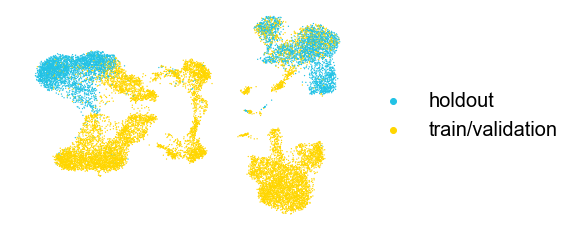

In [8]:
c_in = ['CD8-T', 'NK', 'B', 'DC', 'CD14-Mono']
c_out = ['CD4-T', 'F-Mono']
umap_heldout(pbmc, c_in, c_out, "a")

... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/umap_heldout_4.png


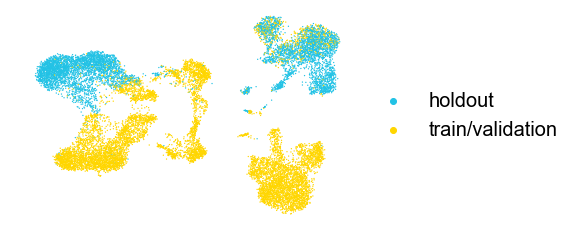

In [9]:
c_in = ['NK', 'B', 'CD14-Mono']
c_out = ['CD4-T', 'F-Mono', 'CD8-T', 'DC']
umap_heldout(pbmc, c_in, c_out, "b")

... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/umap_heldout_6.png


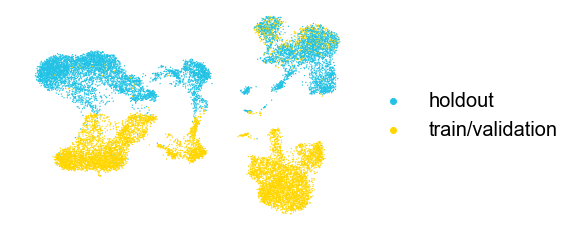

In [10]:
c_in = ['CD14-Mono']
c_out = ['CD4-T', 'F-Mono', 'CD8-T', 'NK', 'B', 'DC']
umap_heldout(pbmc, c_in, c_out, "c")

In [11]:
sc.tl.rank_genes_groups(pbmc, groupby="condition", n_genes=100, method="wilcoxon")
diff_genes = pbmc.uns["rank_genes_groups"]["names"]["stimulated"]

In [18]:
def cell_type_analysis(adata, cell_type, n_out, figure):
    import scipy.sparse as sparse
    if sparse.issparse(adata.X):
        adata.X = adata.X.A
    network = scgen.VAEArith(x_dimension=adata.shape[1], z_dimension=100, model_path=f"../models/pbmc/heldout/{n_out}/models/scgen")
    network.restore_model()
    cell_type_data = adata[(adata.obs["cell_type"] == cell_type)]
    conditions = {"stim": "stimulated", "ctrl": "control"}
    pred_stim, delta = network.predict(adata=cell_type_data,
                                       conditions=conditions,
                                       cell_type_key="cell_type",
                                       condition_key="condition",
                                       celltype_to_predict=cell_type)
    pred_adata = anndata.AnnData(pred_stim, obs={"condition": ["pred"] * len(pred_stim)},
                                 var={"var_names": cell_type_data.var_names})
    all_adata = cell_type_data.concatenate(pred_adata)
    scgen.plotting.reg_mean_plot(all_adata, 
                                 labels={"x": "pred", "y":"stim"},
                                 condition_key="condition",
                                 axis_keys={"x": "pred", "y": conditions["stim"]},
                                 gene_list=diff_genes[:5],
                                 top_100_genes=diff_genes,
                                 legend=False,
                                 fontsize=20,
                                 textsize=14, 
                                 range=[0, 6, 1],
                                 x_coeff=0.35,
                                 show=True,
                                 path_to_save=os.path.join(path_to_save, f"SupplFig7{figure}_{cell_type}_reg_mean.pdf"))
    import matplotlib
    matplotlib.rc('ytick', labelsize=18)
    matplotlib.rc('xtick', labelsize=18)
    sc.pl.violin(all_adata, keys="ISG15", groupby="condition",
                 save=f"_ISG15.pdf",
                 color = "#ee0ef0",
                 show=True)
    os.rename(src=os.path.join(path_to_save, f"violin_ISG15.pdf"), 
              dst=os.path.join(path_to_save, f"SupplFig7{figure}_violin_ISG15_{cell_type}_{n_out}.pdf"))

INFO:tensorflow:Restoring parameters from ../models/pbmc/heldout/2/models/scgen


INFO:tensorflow:Restoring parameters from ../models/pbmc/heldout/2/models/scgen


0.982366139895422
0.9777390703838904


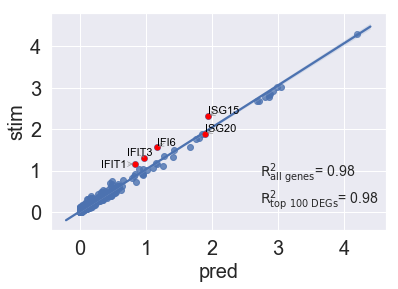

... storing 'cell_type' as categorical
... storing 'condition' as categorical
... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/violin_ISG15.pdf


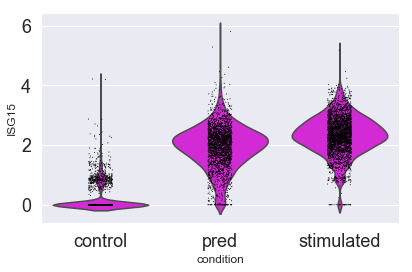

INFO:tensorflow:Restoring parameters from ../models/pbmc/heldout/4/models/scgen


INFO:tensorflow:Restoring parameters from ../models/pbmc/heldout/4/models/scgen


0.9321457503118815
0.9558328299598464


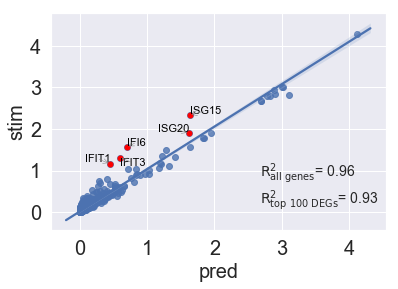

... storing 'cell_type' as categorical
... storing 'condition' as categorical
... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/violin_ISG15.pdf


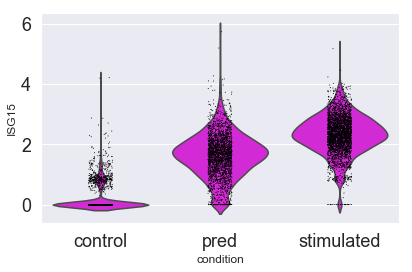

INFO:tensorflow:Restoring parameters from ../models/pbmc/heldout/6/models/scgen


INFO:tensorflow:Restoring parameters from ../models/pbmc/heldout/6/models/scgen


0.8290113175808839
0.9158024043333821


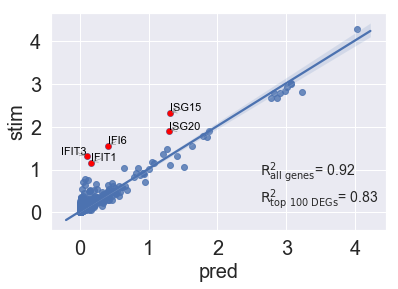

... storing 'cell_type' as categorical
... storing 'condition' as categorical
... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/violin_ISG15.pdf


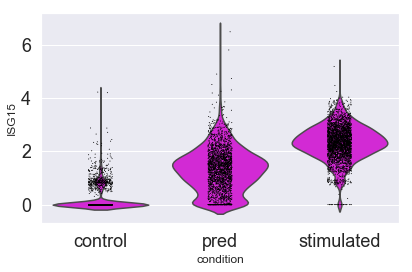

In [19]:
cell_type_analysis(pbmc, "CD4-T", 2, "a")
cell_type_analysis(pbmc, "CD4-T", 4, "b")
cell_type_analysis(pbmc, "CD4-T", 6, "c")

INFO:tensorflow:Restoring parameters from ../models/pbmc/heldout/2/models/scgen


INFO:tensorflow:Restoring parameters from ../models/pbmc/heldout/2/models/scgen


0.9959002030617387
0.9910877202699719


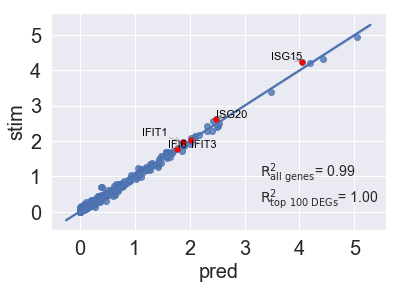

... storing 'cell_type' as categorical
... storing 'condition' as categorical
... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/violin_ISG15.pdf


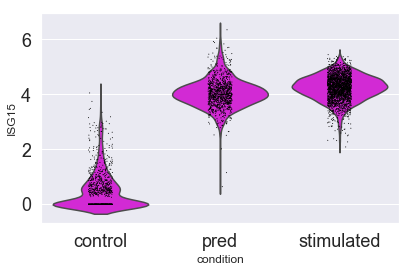

INFO:tensorflow:Restoring parameters from ../models/pbmc/heldout/4/models/scgen


INFO:tensorflow:Restoring parameters from ../models/pbmc/heldout/4/models/scgen


0.9926204114293429
0.9872160857878883


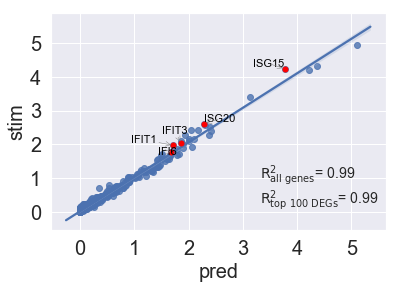

... storing 'cell_type' as categorical
... storing 'condition' as categorical
... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/violin_ISG15.pdf


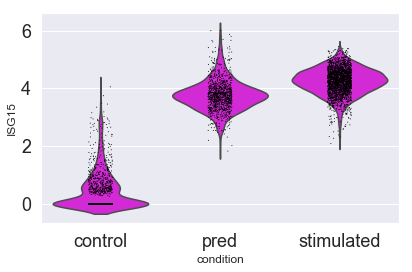

INFO:tensorflow:Restoring parameters from ../models/pbmc/heldout/6/models/scgen


INFO:tensorflow:Restoring parameters from ../models/pbmc/heldout/6/models/scgen


0.993849411721876
0.986765939107507


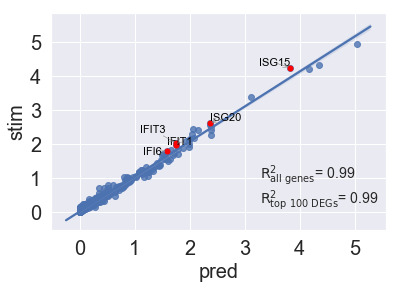

... storing 'cell_type' as categorical
... storing 'condition' as categorical
... storing 'heldout' as categorical


saving figure to file ../results/Figures/Supplemental Figure 7/violin_ISG15.pdf


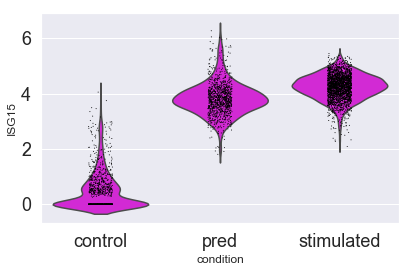

In [20]:
cell_type_analysis(pbmc, "F-Mono", 2, "a")
cell_type_analysis(pbmc, "F-Mono", 4, "b")
cell_type_analysis(pbmc, "F-Mono", 6, "c")